In [1]:
# Imports
from __future__ import print_function
import os, sys
import argparse
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import mdtraj as md
import pyemma
from pyemma.util.contexts import settings
import glob as glob
import tqdm as tqdm
# Structures and Featurization ------------------------------------------------------------------------

ref=md.load('./owlsnest/ref.gro', top='./owlsnest/ref.gro')
top=ref.top
path = '/mnt/c/Users/dnova/Desktop/owlsnest'
#Trajectories ---------------------------------------------------------------------------------------
traj_list = []
for directory in glob.glob('./FOX01_trajs/RUN*/'):
    for filename in os.listdir(directory):
            if filename.endswith('xtc'):
               traj_list.append(os.path.join(directory,filename))


/home/kpman/miniconda3/lib/python3.7/site-packages/mdtraj/core/trajectory.py:419: UserWarning: top= kwarg ignored since file contains topology information
  warnings.warn('top= kwarg ignored since file contains topology information')


In [ ]:
# Data
#distances_data=
clusters=500

In [2]:
# Import TICA data
distances_tica_output=np.load(f'{path}/distances_tica2.5_output.npy',allow_pickle=True)
distances_tica_concatenated = np.concatenate(distances_tica_output)


/home/kpman/miniconda3/lib/python3.7/site-packages/pyemma/plots/plots2d.py:253: UserWarning: figsize=(10, 4) is not an allowed optional parameter and will be ignored
  ' be ignored'.format(key, kwargs[key]))


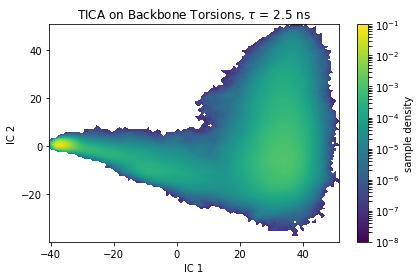

In [3]:
# Plot TICA Density
fig = pyemma.plots.plot_density(*distances_tica_concatenated[:, :2].T,logscale=True, figsize=(10,4))
plt.title('TICA on Backbone Torsions, $\\tau$ = 2.5 ns')
plt.xlabel('IC 1')
plt.ylabel('IC 2')
plt.tight_layout()
#plt.savefig('tica_1.png')

In [4]:
# Import TICA CLuster Centers
cluster_centers = np.load(f'{path}/distances_cluster_500_4_centers.npy',allow_pickle=True)
cluster_dtrajs=list(np.load(f'{path}/distances_cluster_500_4_dtrajs.npy',allow_pickle=True))
distances_dtrajs_concatenated =np.concatenate(np.load(f'{path}/distances_cluster_500_4_dtrajs.npy',allow_pickle=True))


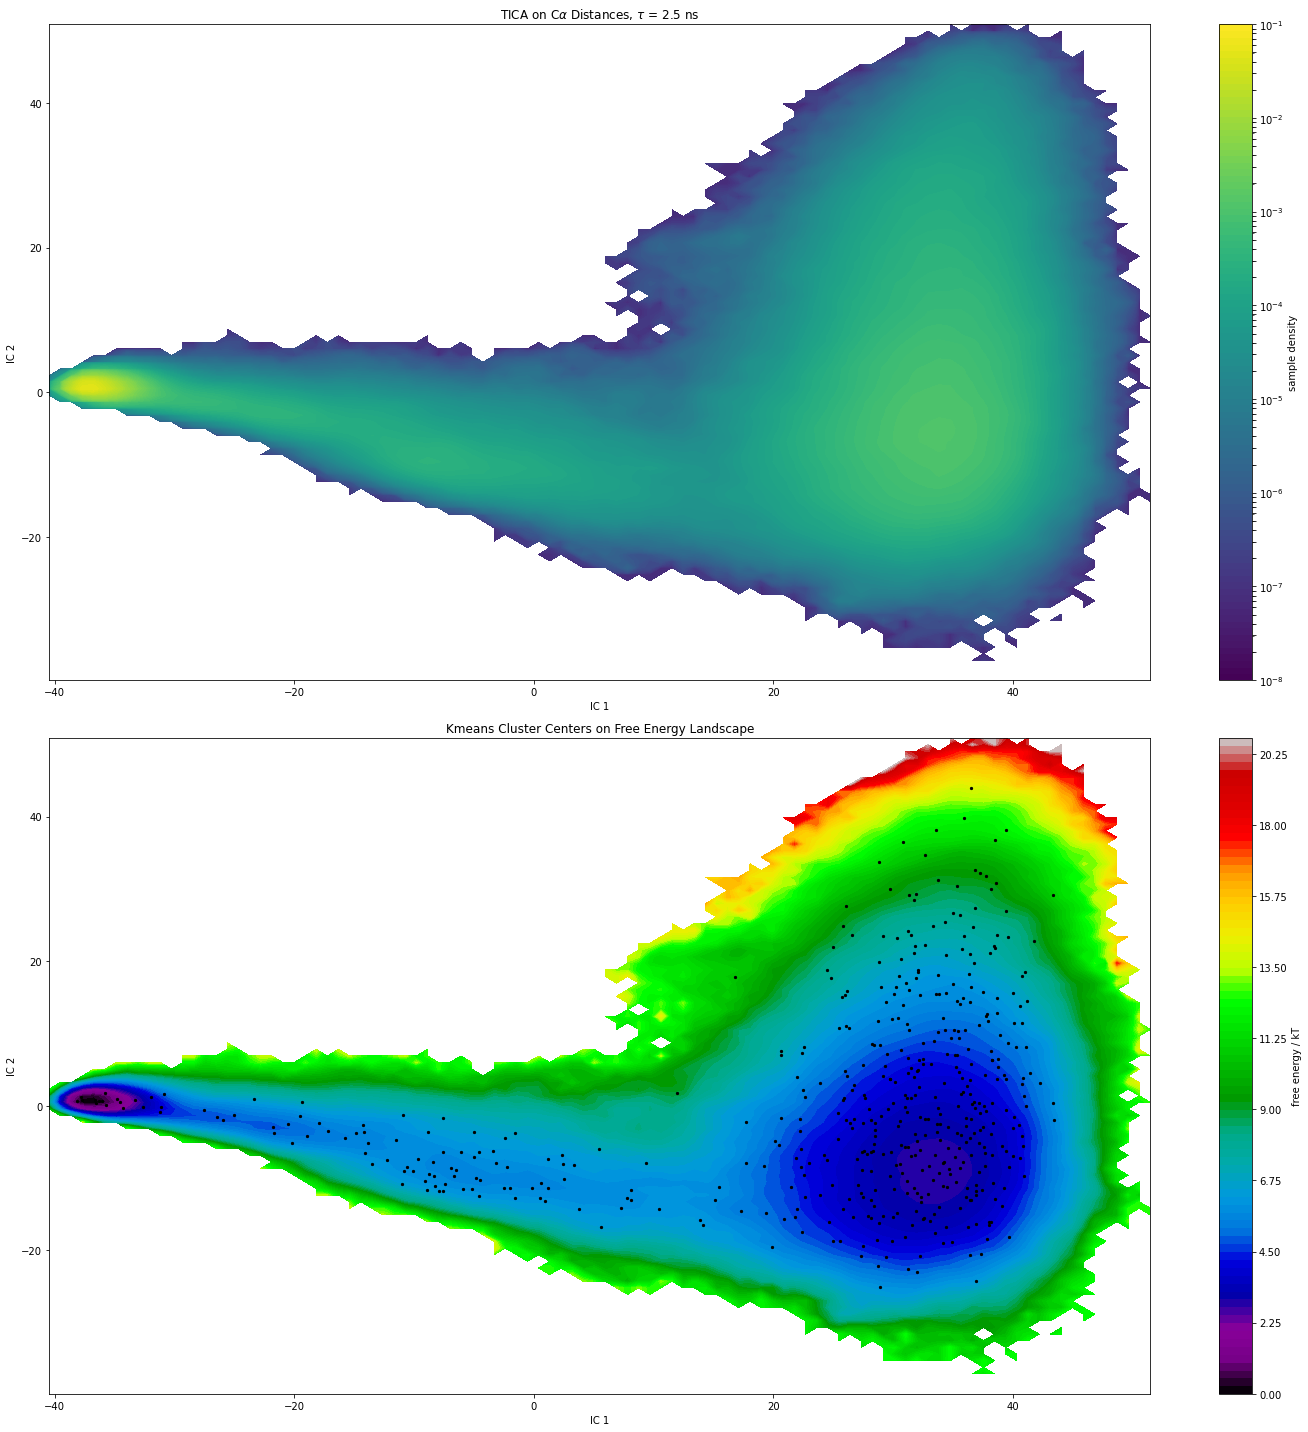

In [8]:
# Tica Density + Free Energy
fig, ax = plt.subplots(2,1,figsize=(20,20))
pyemma.plots.plot_density(*distances_tica_concatenated[:, :2].T,logscale=True, ax=ax[0])
ax[0].set_title('TICA on C$\\alpha$ Distances, $\\tau$ = 2.5 ns')
ax[0].set_xlabel('IC 1')
ax[0].set_ylabel('IC 2')
pyemma.plots.plot_free_energy(
    *distances_tica_concatenated[:, :2].T,
    weights=np.concatenate(distances_msm.trajectory_weights()),
    ax=ax[1],
    legacy=False)
ax[1].scatter(*cluster_centers[:, :2].T, s=5, c='black')
ax[1].set_title('Kmeans Cluster Centers on Free Energy Landscape')
ax[1].set_xlabel('IC 1')
ax[1].set_ylabel('IC 2')
fig.tight_layout()
#fig.savefig('All_tica.png')

Text(0.5, 1.0, 'Implied Timescales for Markov State Model')

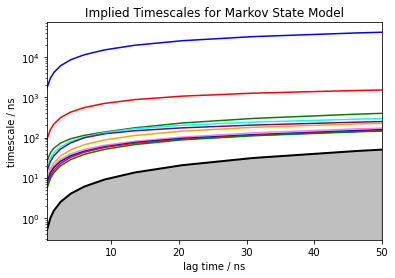

In [6]:
# Implied timescales...done on owlsnest
its = pyemma.msm.its(cluster_dtrajs, lags=100, nits=10) # was 50 before lags
fig, ax = plt.subplots()
pyemma.plots.plot_implied_timescales(its, units='ns', dt=0.5, ax=ax); # was 2.5
ax.set_title('Implied Timescales for Markov State Model')

In [7]:
# Build MSM.. Lag from ITS plots
distances_msm = pyemma.msm.bayesian_markov_model( cluster_dtrajs, lag=60, dt_traj='0.5 ns')
print('fraction of states used = {:.2f}'.format(distances_msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(distances_msm.active_count_fraction))

fraction of states used = 1.00
fraction of counts used = 1.00


In [9]:
# Only Use Active Trajs
distances_dtrajs_concatenated=np.concatenate(distances_msm.dtrajs_active)
print(len(distances_dtrajs_concatenated))

13545589


In [10]:
# Is my MSM reversible?
distances_msm.reversible

True

(<Figure size 648x648 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f292aaa8610>,
       dtype=object))

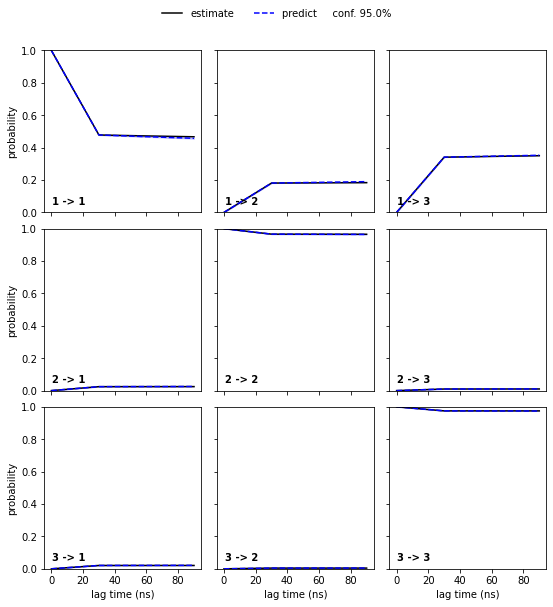

In [11]:
# CK test for efficacy
nstates = 3
distances_cktest = distances_msm.cktest(nstates, mlags=4)
pyemma.plots.plot_cktest(distances_cktest, dt=0.5, units='ns')


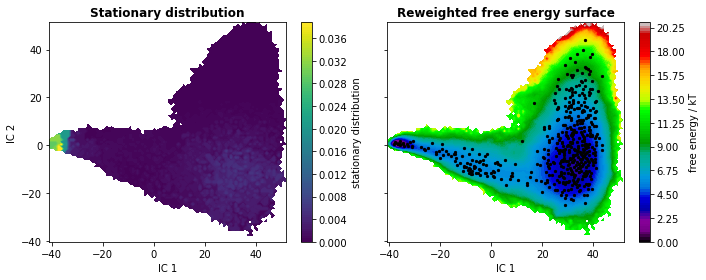

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
pyemma.plots.plot_contour(
    *distances_tica_concatenated[:,:2].T,
    distances_msm.pi[distances_dtrajs_concatenated],
    ax=axes[0],
   mask=True,
    cbar_label='stationary distribution')
pyemma.plots.plot_free_energy(
    *distances_tica_concatenated[:, :2].T,
    weights=np.concatenate(distances_msm.trajectory_weights()),
    ax=axes[1],
    legacy=False)
axes[1].scatter(*cluster_centers[:, :2].T, s=5, c='black')
for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')
fig.tight_layout()

The first eigenvector is one: True (min=0.9999999999979753, max=1.000000000004428)


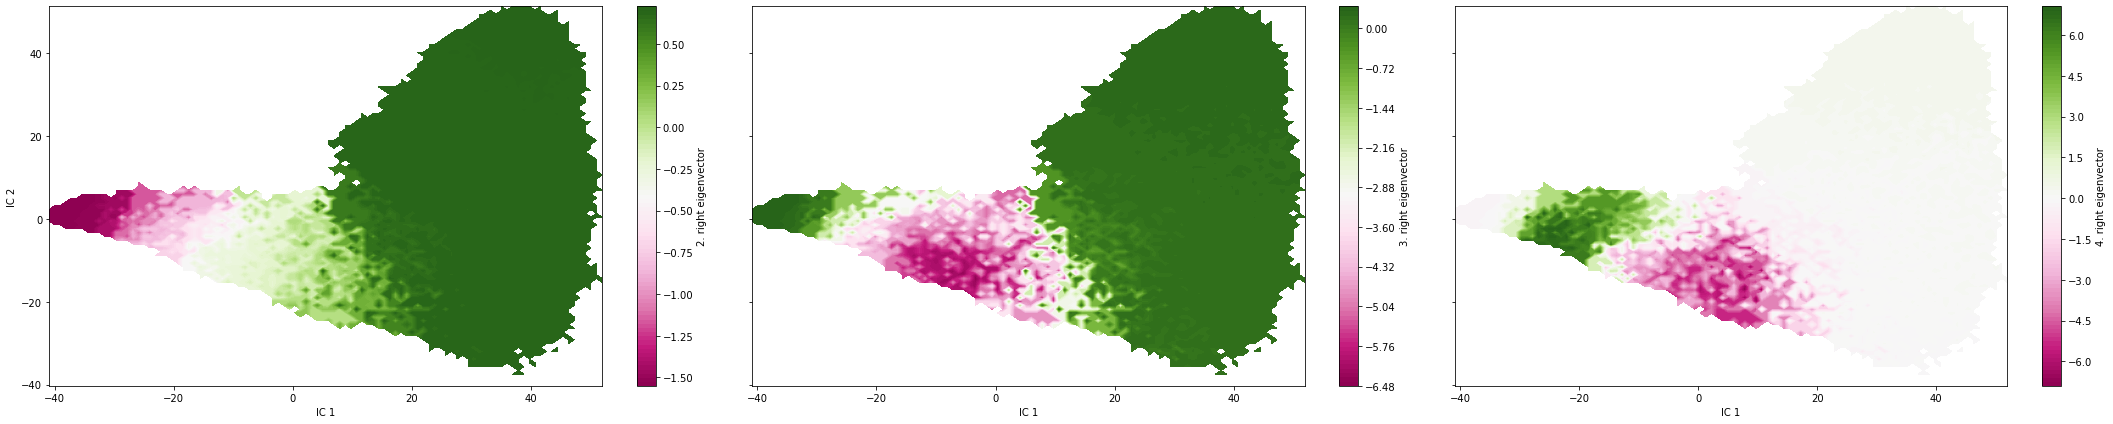

In [13]:
eigvec = distances_msm.eigenvectors_right()
print('The first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(1, 3, figsize=(30, 6), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *distances_tica_concatenated[:, :2].T,
        eigvec[distances_dtrajs_concatenated, i + 1],
        ax=ax,
        cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2),
        mask=True)
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()

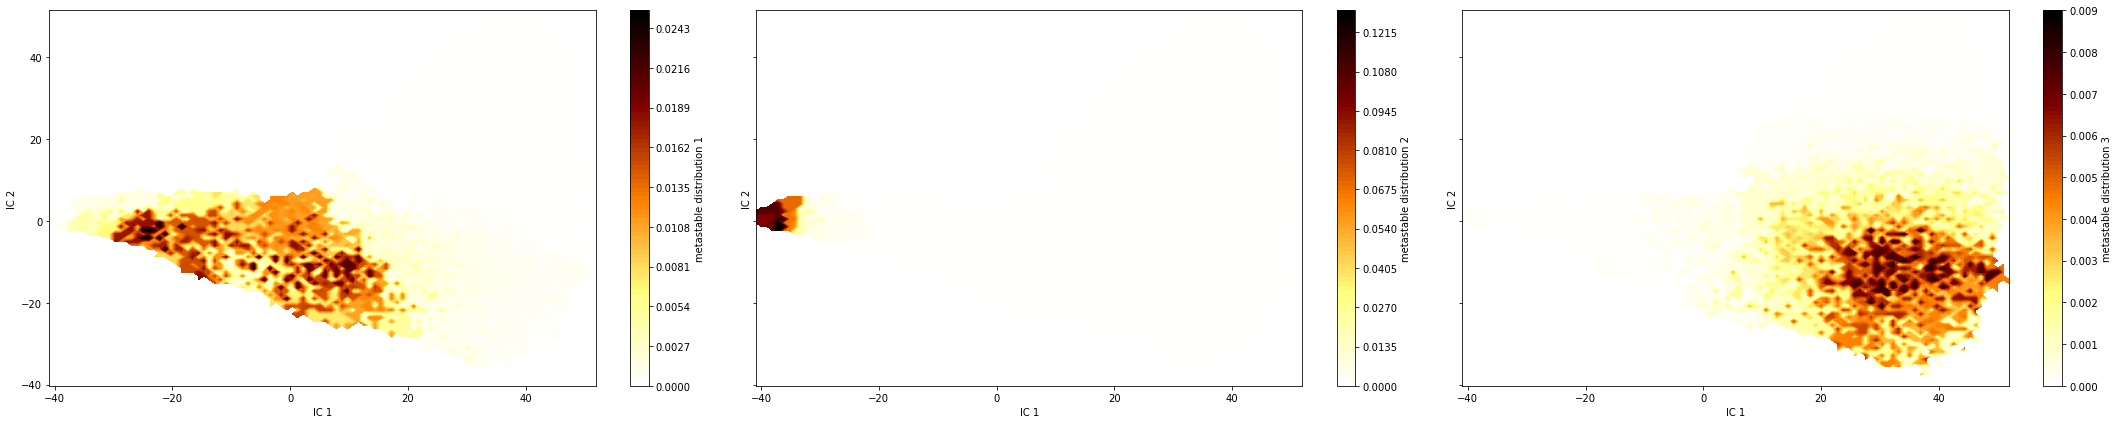

In [14]:
#nstates=3
#distances_msm.pcca(nstates)
fig, axes = plt.subplots(1, 3, figsize=(30, 6), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *distances_tica_concatenated[:, :2].T,
        distances_msm.metastable_distributions[i][distances_dtrajs_concatenated],
        ax=ax,
        cmap='afmhot_r',
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('IC 1')
    ax.set_ylabel('IC 2')
fig.tight_layout()

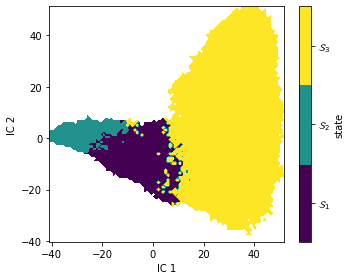

In [15]:
metastable_traj = distances_msm.metastable_assignments[distances_dtrajs_concatenated]

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *distances_tica_concatenated[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig.tight_layout()

In [16]:
print('state\tπ\t\tG/kT')
for i, s in enumerate(distances_msm.metastable_sets):
    p = distances_msm.pi[s].sum()
    print('{}\t{:f}\t{:f}'.format(i + 1, p, -np.log(p)))
    

state	π		G/kT
1	0.036847	3.300968
2	0.296301	1.216380
3	0.666852	0.405187


In [17]:

metastable_traj = distances_msm.metastable_assignments[distances_dtrajs_concatenated]
highest_membership =distances_msm.metastable_distributions.argmax(1)
coarse_state_centers = cluster_centers[distances_msm.active_set[highest_membership]]
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = distances_msm.mfpt(
            distances_msm.metastable_sets[i],
            distances_msm.metastable_sets[j])*1e-3

inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

from pandas import DataFrame
print('MFPT / us:')
DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))


MFPT / us:


1      2      3
1   0.00  34.28  14.54
2  17.91   0.00  41.08
3  31.14  80.49   0.00

percentage       	path
-------------------------------------
0.9180718617711373  	 [0 1 2]
0.08192813822886279  	 [0 2]


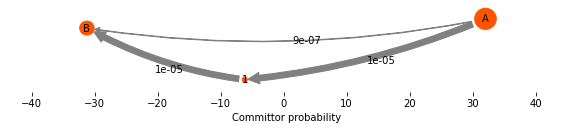

In [18]:
def avg_by_set(x, sets):
    # compute mean positions of sets. This is important because of some technical points the set order
    # in the coarse-grained TPT object can be different from the input order.
    avg = np.zeros(len(sets))
    for i in range(len(sets)):
        I = list(sets[i])
        avg[i] = np.mean(x[I])
    return avg
sets=distances_msm.metastable_sets
cc_x = cluster_centers[:,0]
cc_y = cluster_centers[:,1]
xavg = avg_by_set(cc_x, sets)
A = sets[xavg.argmax()]
B = sets[xavg.argmin()]
fluxAB = pyemma.msm.tpt(distances_msm, A, B)
cg, cgflux = fluxAB.coarse_grain(sets)
avgpos = np.zeros((nstates,2))
avgpos[:,0] = avg_by_set(cc_x, cg)
avgpos[:,1] = avg_by_set(cc_y, cg)
fig,_ = pyemma.plots.plot_flux(cgflux, avgpos, cgflux.stationary_distribution, max_width=10, max_height=7)
paths, path_fluxes = cgflux.pathways(fraction=0.99)
print( 'percentage       \tpath')
print('-------------------------------------')
for i in range(len(paths)):
    print((path_fluxes[i] / np.sum(path_fluxes)),' \t', paths[i])

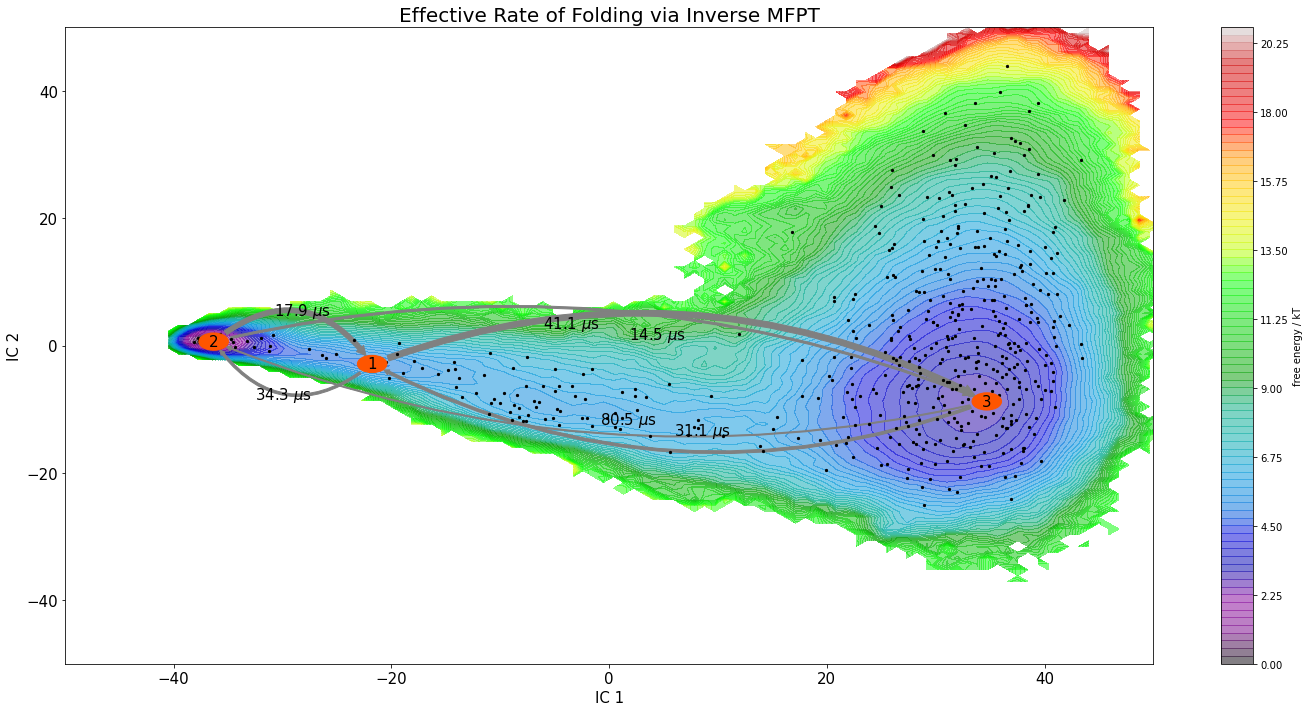

In [19]:
markersize=[]
for i, s in enumerate(distances_msm.metastable_sets):
    p = distances_msm.pi[s].sum()
    markersize.append(p * 10000)
fig, ax = plt.subplots(figsize=(20,10))
pyemma.plots.plot_network(inverse_mfpt,pos=coarse_state_centers[:, :2],
    figpadding=0,
    state_labels=np.arange(1,nstates+1),                      
    arrow_label_format='%.1f $\\mu$s',
    arrow_labels=mfpt,
    arrow_curvature=3,
    size=15,
    show_frame=True, ax=ax, xticks=True, yticks=True)
pyemma.plots.plot_free_energy(
    *distances_tica_concatenated[:, :2].T,
    weights=np.concatenate(distances_msm.trajectory_weights()),
    ax=ax,
    legacy=False, alpha=0.5, zorder=0)

ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
ax.tick_params(axis='both', which='major', labelsize=15)
#ax.scatter(coarse_state_centers[:,0],coarse_state_centers[:,1], s=markersize, c='yellow',edgecolors='black', alpha=0.5)
ax.scatter(*cluster_centers[:, :2].T, s=5, c='black')
ax.set_xlabel('IC 1', size=15)
ax.set_ylabel('IC 2', size = 15)
ax.set_title('Effective Rate of Folding via Inverse MFPT', size =20)
fig.tight_layout()
fig.savefig('Effective_rate.png')

In [ ]:
distances_msm.save('msm_30_500_good',overwrite=True)


In [ ]:
tic1 = np.load(f'{path}/500_cluster_4/tic1_list_500.npy',allow_pickle=True)

In [ ]:
import pandas as pd
df1 = pd.DataFrame(cluster_centers_[ic1_list[::-1],:3],columns = ['tIC1', 'tIC2', 'tIC3'])
df2 = pd.DataFrame(data=sasa,columns=list(top.residues))
df3 = pd.DataFrame(ic1_list[::-1],columns=['Cluster Center'])
df4 = pd.DataFrame(np.arange(1,101,dtype=int),columns=['Frame'])
data =pd.concat([df4,df3,df1,df2],axis=1)
data = data.set_index(['Frame','Cluster Center'])
data.to_csv(f'{path}/SASA.csv')

In [20]:
markov_samples = [smpl for smpl in distances_msm.sample_by_state(20)]
samples = [pyemma.coordinates.save_traj(traj_list, smpl,stride=0.5, outfile=None, top=top)
            for smpl in markov_samples]



In [21]:
# Shrake-rupley algorithm for SASA
from mdtraj import shrake_rupley
markov_sasa_all = [shrake_rupley(sample, mode='residue')
                   for sample in samples]

In [22]:
# TRP SASA for TRP Fluorescence (sp?)
import re
test=[]
for i in top.residues:
    test.append(f'{i}')
r = re.compile(".*TRP")
trp = list(filter(r.match, test)) # Read Note
print(trp)

['TRP11', 'TRP40', 'TRP60', 'TRP87', 'TRP88']


In [81]:
residues = [ref.top.residue(i) for i in np.arange(100)]
map = np.arange(150,250)

In [89]:
pd.set_option('display.max_rows', None)
map_df = pd.DataFrame(data={'Residue':residues,'PDB':map})
map_df

Residue  PDB
0     SER1  150
1     LYS2  151
2     SER3  152
3     SER4  153
4     SER5  154
5     SER6  155
6     ARG7  156
7     ARG8  157
8     ASN9  158
9    ALA10  159
10   TRP11  160
11   GLY12  161
12   ASN13  162
13   LEU14  163
14   SER15  164
15   TYR16  165
16   ALA17  166
17   ASP18  167
18   LEU19  168
19   ILE20  169
20   THR21  170
21   LYS22  171
22   ALA23  172
23   ILE24  173
24   GLU25  174
25   SER26  175
26   SER27  176
27   ALA28  177
28   GLU29  178
29   LYS30  179
30   ARG31  180
31   LEU32  181
32   THR33  182
33   LEU34  183
34   SER35  184
35   GLN36  185
36   ILE37  186
37   TYR38  187
38   GLU39  188
39   TRP40  189
40   MET41  190
41   VAL42  191
42   LYS43  192
43   SER44  193
44   VAL45  194
45   PRO46  195
46   TYR47  196
47   PHE48  197
48   LYS49  198
49   ASP50  199
50   LYS51  200
51   GLY52  201
52   ASP53  202
53   SER54  203
54   ASN55  204
55   SER56  205
56   SER57  206
57   ALA58  207
58   GLY59  208
59   TRP60  209
60   LYS61  210
61   ASN62  211
62   SER63  212
63   ILE64  213
64   ARG65  214
65   HIS66  215
66   ASN67  216
67   LEU68  217
68   SER69  218
69   LEU70  219
70   HIS71  220
71   SER72  221
72   LYS73  222
73   PHE74  223
74   ILE75  224
75   ARG76  225
76   VAL77  226
77   GLN78  227
78   ASN79  228
79   GLU80  229
80   GLY81  230
81   THR82  231
82   GLY83  232
83   LYS84  233
84   SER85  234
85   SER86  235
86   TRP87  236
87   TRP88  237
88   MET89  238
89   LEU90  239
90   ASN91  240
91   PRO92  241
92   GLU93  242
93   GLY94  243
94   GLY95  244
95   LYS96  245
96   SER97  246
97   GLY98  247
98   LYS99  248
99  SER100  249

In [90]:
# SASA for Specific mutation loci in my system
markov_average_sasa = []
for i in [3,55,2,32,33,16]:
          markov_average_sasa.append(np.array(markov_sasa_all).mean(axis=1)[:,i])

/home/kpman/miniconda3/lib/python3.7/site-packages/pyemma/plots/plots2d.py:253: UserWarning: labelsize=15 is not an allowed optional parameter and will be ignored
  ' be ignored'.format(key, kwargs[key]))


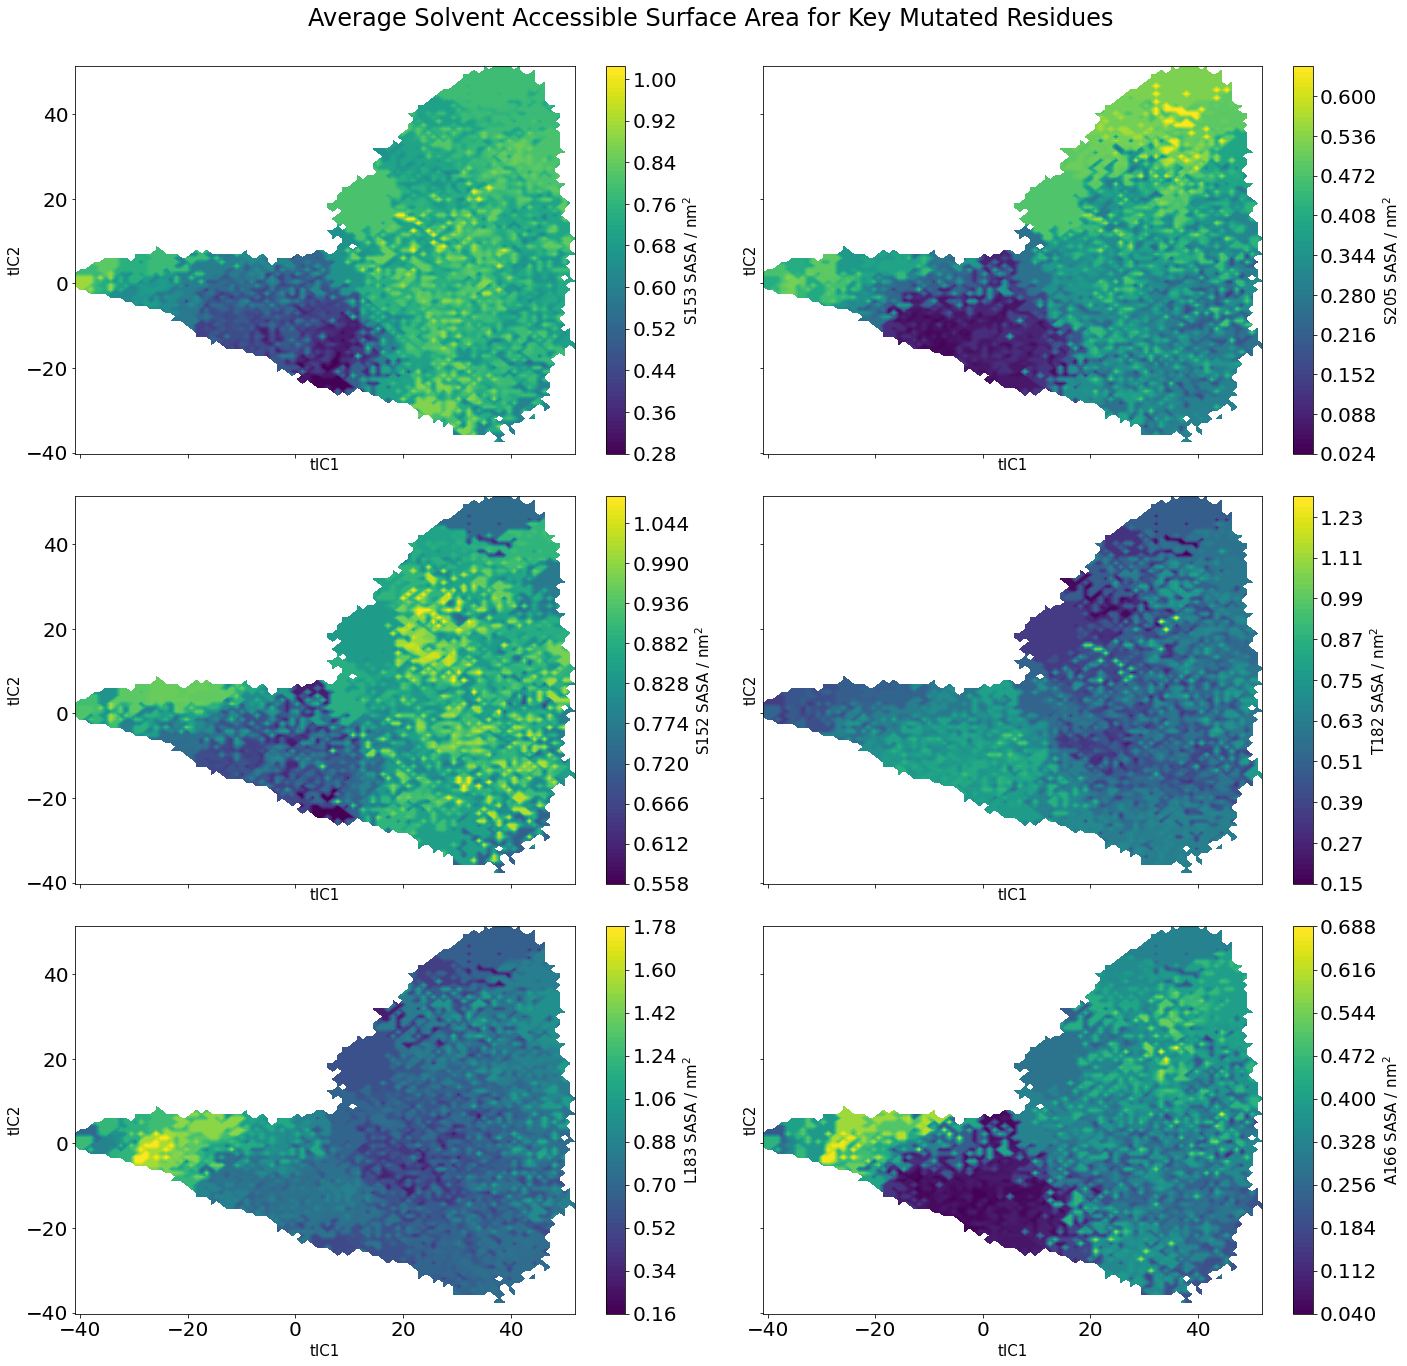

In [91]:
# Mutation Loci SASA
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.rc('font', size=15)
labels = ['S153','S205','S152','T182','L183','A166']
fig, axes = plt.subplots(3, 2, figsize=(20, 20), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *distances_tica_concatenated[:, :2].T,
        markov_average_sasa[i][distances_dtrajs_concatenated],
        ax=ax,
        mask=True,
        cbar=True,
        cbar_label=r'%s SASA / nm$^2$'%labels[i], labelsize=15)
    ax.set_xlabel('tIC1')
    ax.set_ylabel('tIC2')

fig.suptitle('Average Solvent Accessible Surface Area for Key Mutated Residues', size =24)
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) 
fig.savefig('SASA_map.png')

/home/kpman/miniconda3/lib/python3.7/site-packages/pyemma/plots/plots2d.py:253: UserWarning: labelsize=15 is not an allowed optional parameter and will be ignored
  ' be ignored'.format(key, kwargs[key]))


IndexError: list index out of range

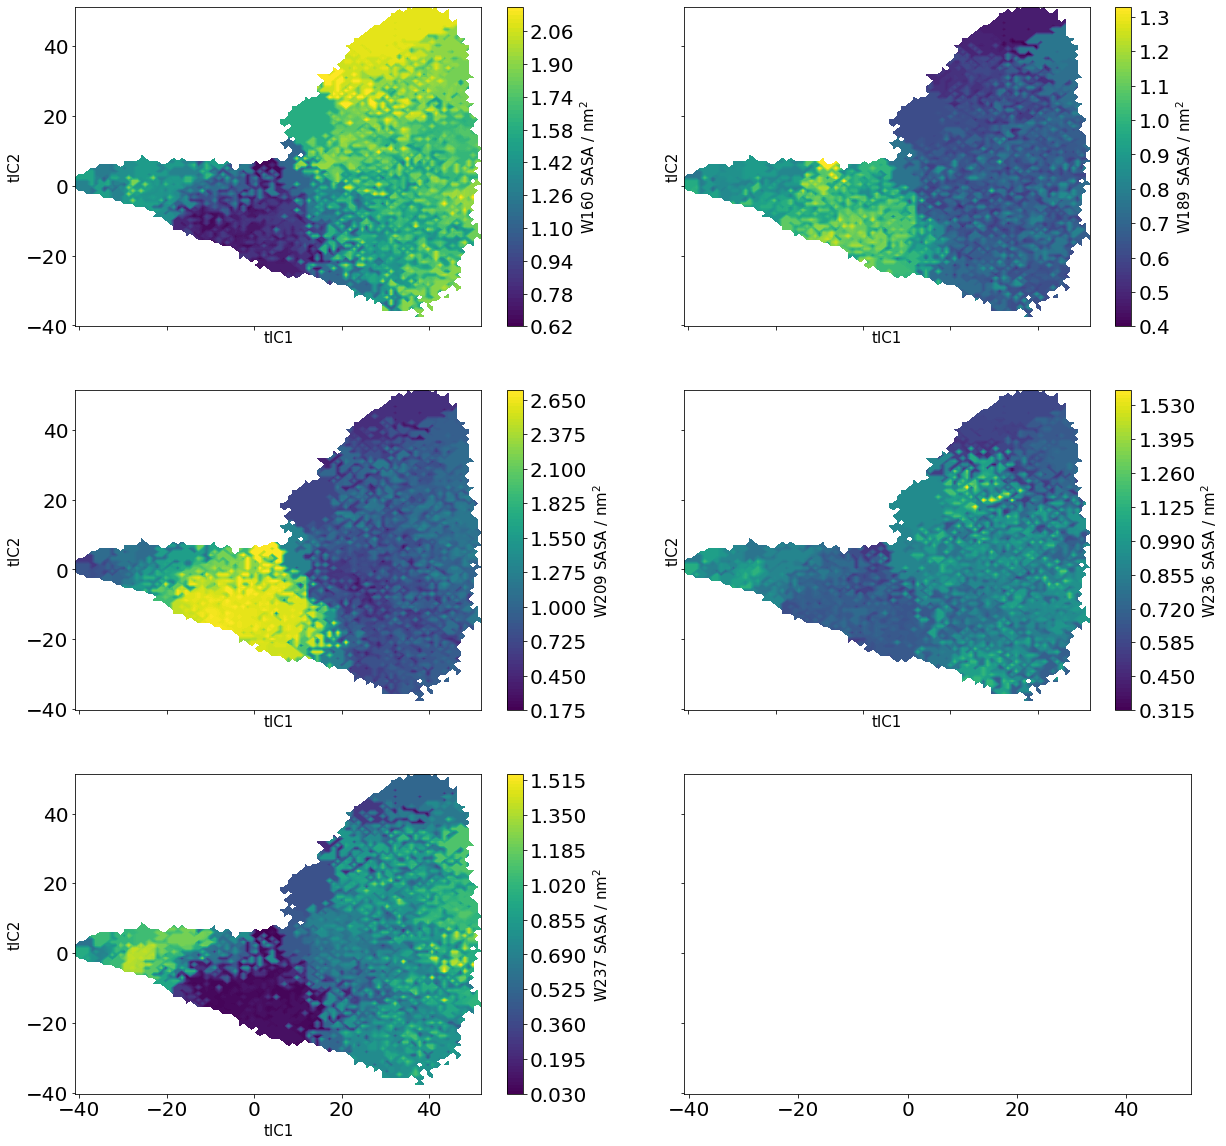

In [694]:
# TRP SASA maps

markov_average_trp_sasa = []
for i in [10,39,59,86,87]:
          markov_average_trp_sasa.append(np.array(markov_sasa_all).mean(axis=1)[:,i])
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.rc('font', size=15)
labels = ['W160','W189','W209','W236','W237']
fig, axes = plt.subplots(3, 2, figsize=(20, 20), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *distances_tica_concatenated[:, :2].T,
        markov_average_trp_sasa[i][distances_dtrajs_concatenated],
        ax=ax,
        mask=True,
        cbar=True,
        cbar_label=r'%s SASA / nm$^2$'%labels[i], labelsize=15)
    ax.set_xlabel('tIC1')
    ax.set_ylabel('tIC2')

fig.suptitle('Average Solvent Accessible Surface Area for Key Mutated Residues', size =24)
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) 
#fig.savefig('SASA_map.png')

/home/kpman/miniconda3/lib/python3.7/site-packages/pyemma/util/statistics.py:59: UserWarning: confidence interval for constant data is not meaningful
  warnings.warn('confidence interval for constant data is not meaningful')
/home/kpman/miniconda3/lib/python3.7/site-packages/pyemma/util/statistics.py:59: UserWarning: confidence interval for constant data is not meaningful
  warnings.warn('confidence interval for constant data is not meaningful')
/home/kpman/miniconda3/lib/python3.7/site-packages/pyemma/util/statistics.py:59: UserWarning: confidence interval for constant data is not meaningful
  warnings.warn('confidence interval for constant data is not meaningful')
/home/kpman/miniconda3/lib/python3.7/site-packages/pyemma/util/statistics.py:59: UserWarning: confidence interval for constant data is not meaningful
  warnings.warn('confidence interval for constant data is not meaningful')
/home/kpman/miniconda3/lib/python3.7/site-packages/pyemma/util/statistics.py:59: UserWarning: confid

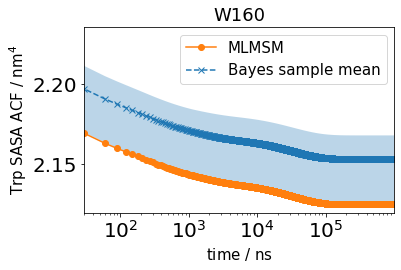

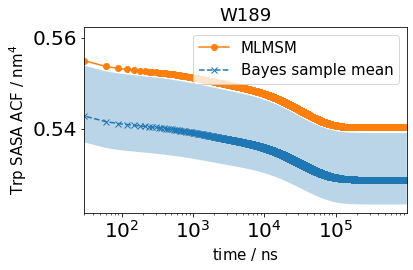

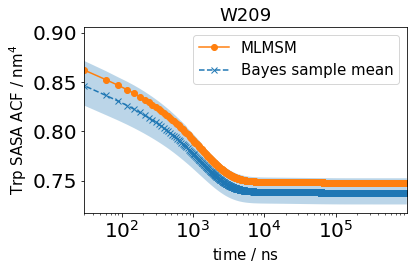

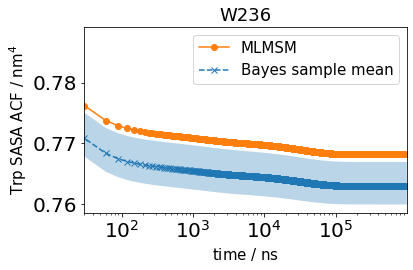

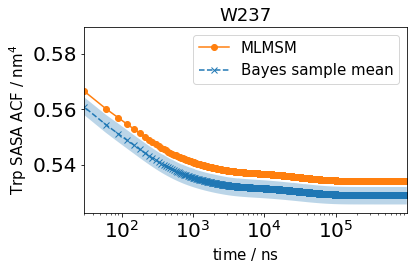

In [92]:
# Attempt at spectral prediction....the rest of this is work in progress
labels = ['W160','W189','W209','W236','W237']
mlmsm = pyemma.msm.estimate_markov_model(cluster_dtrajs, lag=60, dt_traj='0.5 ns')
for i in np.arange(len(markov_average_trp_sasa)):   
    eq_time_ml, eq_acf_ml = mlmsm.correlation(markov_average_trp_sasa[i], maxtime=1000000)

    eq_time_bayes, eq_acf_bayes = distances_msm.sample_mean(
        'correlation',
        np.array(markov_average_trp_sasa[i]),
        maxtime=1000000)

    eq_acf_bayes_ci_l, eq_acf_bayes_ci_u = distances_msm.sample_conf(
        'correlation',
        np.array(markov_average_trp_sasa[i]),
        maxtime=1000000)

    fig, ax = plt.subplots()
    ax.plot(eq_time_ml, eq_acf_ml, '-o', color='C1', label='MLMSM')
    ax.plot(
        eq_time_bayes,
        eq_acf_bayes,
        '--x',
        color='C0',
        label='Bayes sample mean')
    ax.fill_between(
        eq_time_bayes,
        eq_acf_bayes_ci_l[1],
        eq_acf_bayes_ci_u[1],
        facecolor='C0',
        alpha=0.3)
    ax.semilogx()

    ax.set_xlim((eq_time_ml[1], eq_time_ml[-1]))
    ax.set_xlabel(r'time / $\mathrm{ns}$')
    ax.set_ylabel(r'Trp SASA ACF / $\mathrm{nm}^4$')
    ax.set_title(labels[i])
    ax.legend()
    fig.tight_layout()

/home/kpman/miniconda3/lib/python3.7/site-packages/pyemma/util/statistics.py:59: UserWarning: confidence interval for constant data is not meaningful
  warnings.warn('confidence interval for constant data is not meaningful')
/home/kpman/miniconda3/lib/python3.7/site-packages/pyemma/util/statistics.py:59: UserWarning: confidence interval for constant data is not meaningful
  warnings.warn('confidence interval for constant data is not meaningful')
/home/kpman/miniconda3/lib/python3.7/site-packages/pyemma/util/statistics.py:59: UserWarning: confidence interval for constant data is not meaningful
  warnings.warn('confidence interval for constant data is not meaningful')
/home/kpman/miniconda3/lib/python3.7/site-packages/pyemma/util/statistics.py:59: UserWarning: confidence interval for constant data is not meaningful
  warnings.warn('confidence interval for constant data is not meaningful')
/home/kpman/miniconda3/lib/python3.7/site-packages/pyemma/util/statistics.py:59: UserWarning: confid

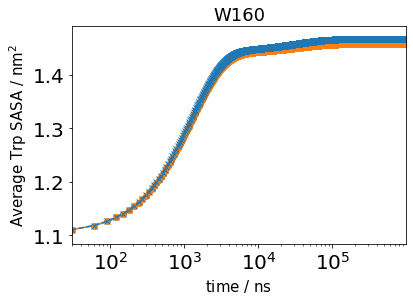

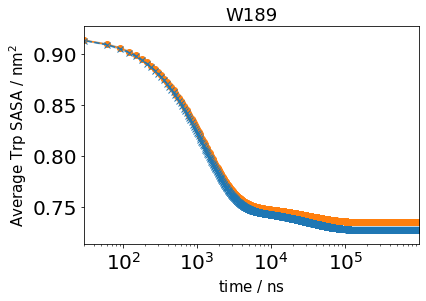

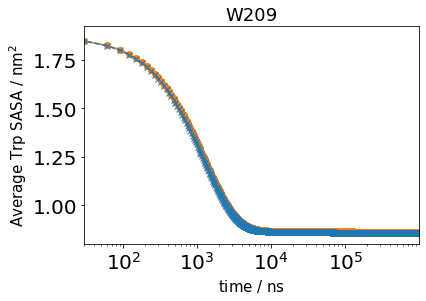

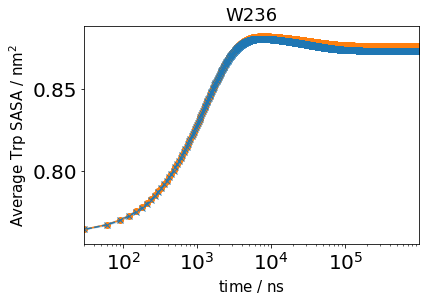

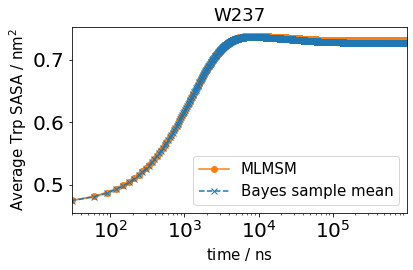

In [93]:
labels = ['W160','W189','W209','W236','W237']
for i in np.arange(len(markov_average_trp_sasa)):
    eq_time_ml, eq_relax_ml = mlmsm.relaxation(
        distances_msm.metastable_distributions[0],
        markov_average_trp_sasa[i], 
        maxtime=1000000)

    eq_time_bayes, eq_relax_bayes = distances_msm.sample_mean(
        'relaxation',
        distances_msm.metastable_distributions[0],
        np.array(markov_average_trp_sasa[i]),
        maxtime=1000000)

    eq_relax_bayes_CI_l, eq_relax_bayes_CI_u = distances_msm.sample_conf(
         'relaxation',
         distances_msm.metastable_distributions[0],
        np.array(markov_average_trp_sasa[i]),
        maxtime=1000000)

    fig, ax = plt.subplots()
    ax.plot(eq_time_ml, eq_relax_ml, '-o', color='C1', label='MLMSM')
    ax.plot(
        eq_time_bayes,
        eq_relax_bayes,
        '--x',
        color='C0',
        label='Bayes sample mean')
    ax.fill_between(
         eq_time_bayes,
        eq_relax_bayes_CI_l[1],
        eq_relax_bayes_CI_u[1],
        facecolor='C0',
        alpha=0.3)
    ax.semilogx()

    ax.set_xlim((eq_time_ml[1], eq_time_ml[-1]))
    ax.set_xlabel(r'time / $\mathrm{ns}$')
    ax.set_ylabel(r'Average Trp SASA / $\mathrm{nm}^2$')
    ax.set_title(labels[i])
ax.legend()
fig.tight_layout()

In [94]:
import pandas as pd
data = []
for i in np.arange(len(markov_average_trp_sasa)):
    state2ensemble = np.abs(distances_msm.expectation(markov_average_trp_sasa[i]) -
                        distances_msm.metastable_distributions.dot(np.array(markov_average_trp_sasa[i])))
    data.append(np.round(state2ensemble, 3))
S = np.sum([distances_msm.expectation(i) for i in markov_average_trp_sasa])
O = np.array([distances_msm.metastable_distributions.dot(np.array(i))for i in markov_average_trp_sasa])
totO = O.sum(axis=0)
data.append(np.round(np.abs(S-totO), 3))
labels.append('Total')
df = pd.DataFrame(data,index=labels,columns=['${\Delta}$S1 -> <O>','${\Delta}$S2 -> <O>','${\Delta}$S3 -> <O>'])
df

${\Delta}$S1 -> <O>  ${\Delta}$S2 -> <O>  ${\Delta}$S3 -> <O>
W160                 0.356                0.157                0.092
W189                 0.183                0.140                0.074
W209                 1.009                0.010                0.056
W236                 0.115                0.076                0.027
W237                 0.263                0.104                0.031
Total                0.458                0.151                0.096

In [41]:
traj_lengths = []
for i in traj_list:
    trj = md.load(i, top=top)
    traj_lengths.append(trj.n_frames*0.5)

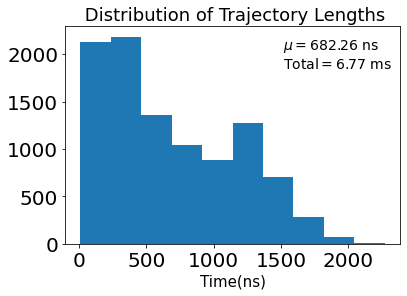

In [42]:
fig,ax = plt.subplots()
ax.hist(np.array(traj_lengths))
ax.set_xlabel('Time(ns)')
ax.set_title(' Distribution of Trajectory Lengths')
mu = np.array(traj_lengths).mean()
total =np.sum(traj_lengths)*10**(-6)
textstr = '\n'.join((
    r'$\mu=%.2f$ ns' % (mu, ),
    r'$\mathrm{Total}=%.2f$ ms' % (total, )))

ax.text(0.65, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top')
fig.show()

In [43]:
from tqdm import tqdm
sel = top.select('resid 5 to 95 and backbone')
ref_sel = ref.topology.select('resid 5 to 95 and backbone')
RMSD = []
for i in tqdm(traj_list):
    traj = md.load(i,top=top)
    RMSD.append(md.rmsd(traj,ref,0,atom_indices=sel,ref_atom_indices=ref_sel))

100%|██████████| 9927/9927 [40:33<00:00,  4.08it/s]  


Text(8.3, 0.14, '$\\mu=9.30$ $\\AA$')

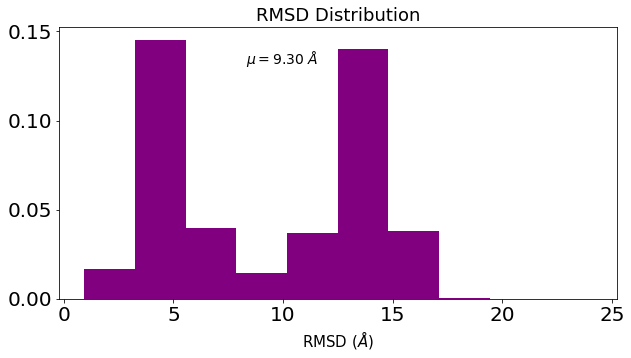

In [674]:
fig,ax = plt.subplots(figsize=(10,5))
ax.hist(np.concatenate(np.array(RMSD))*10,color='purple',density=True)
ax.set_xlabel('RMSD ($\AA$)')
ax.set_title('RMSD Distribution')
mu0 = np.concatenate(np.array(RMSD)).mean()*10
textstr = r'$\mu=%.2f$ $\AA$' % mu0
ax.text(8.3,0.14, textstr,  fontsize=14,
        verticalalignment='top')

In [44]:
minim=[]
start=[]
for i in np.arange(len(RMSD)):
    min = np.min(RMSD[i])
    starting = RMSD[i][0]
    minim.append(min*10)
    start.append(starting*10)

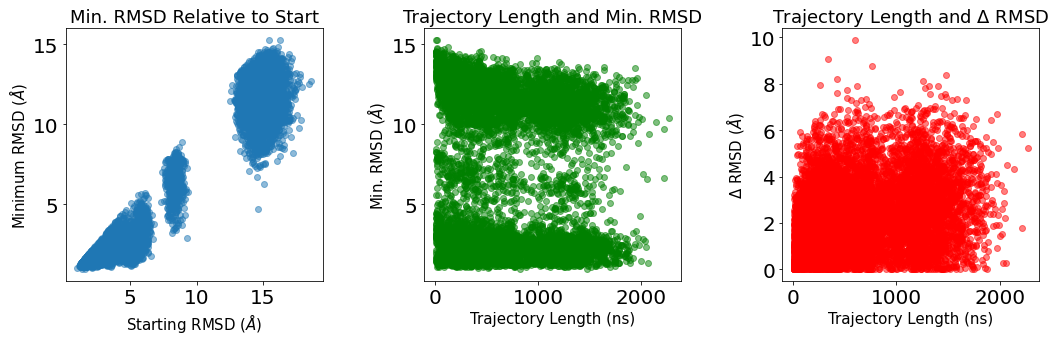

In [45]:
delta_RMSD = np.abs(np.array(minim)-np.array(start))
fig,ax = plt.subplots(1,3, figsize = (15,5))
ax[0].scatter(np.array(start),np.array(minim), alpha=0.5)
#ax[0].axhline(y=3, color='r', linestyle='-')
ax[0].set_xlabel('Starting RMSD ($\AA$)')
ax[0].set_ylabel('Minimum RMSD ($\AA$)')
ax[0].set_title('Min. RMSD Relative to Start')
ax[1].scatter(np.array(traj_lengths), np.array(minim), alpha=0.5, color='green')
#ax[1].axvline(x=1900, color='blue', linestyle='-')
ax[1].set_xlabel('Trajectory Length (ns)')
ax[1].set_ylabel('Min. RMSD ($\AA$)')
ax[1].set_title('Trajectory Length and Min. RMSD')
ax[2].scatter(np.array(traj_lengths), delta_RMSD, alpha=0.5, color='red')
ax[2].set_xlabel('Trajectory Length (ns)')
ax[2].set_ylabel('$\Delta$ RMSD ($\AA$)')
ax[2].set_title('Trajectory Length and $\Delta$ RMSD')
fig.tight_layout()

In [678]:
arr = np.where((np.array(minim) < 2.9) & (np.array(minim) > 2.7))
plot1 = [os.path.basename(traj_list[arr[0][0]]),arr[0][0],np.round(minim[arr[0][0]],1), np.round(start[arr[0][0]],1)]
df1 = pd.DataFrame(np.array(plot1),['Traj','index','Min. RMSD','Start RMSD']).T
df1

Traj index Min. RMSD Start RMSD
0  RUN0_CLONE371.xtc   303       2.9        9.2

In [611]:
long_trajs = np.where(np.array(traj_lengths) > 1900)
plot2 = []
for i in long_trajs[0]:
    plot2.append([os.path.basename(traj_list[i]),i,np.round(minim[i],1),int(traj_lengths[i])])
df2 = pd.DataFrame(np.array(plot2),columns=['Traj','index','Min. RMSD', 'Traj_length'])
df2['Min. RMSD'] = df2['Min. RMSD'].astype(float)
df2 = df2.sort_values('Min. RMSD')

In [612]:
high_delta = np.where(delta_RMSD > 7)
plot3 = []
for i in high_delta[0]:
    plot3.append([os.path.basename(traj_list[i]),i,np.round(delta_RMSD[i],1),int(traj_lengths[i])])
df3 = pd.DataFrame(np.array(plot3),columns=['Traj','index','$\Delta$ RMSD','Traj_length'])
df3 = df3.sort_values('$\Delta$ RMSD', ascending=False)


In [679]:
np.save('FOX01_RMSD',RMSD)
df1.to_pickle('start_v_min')
df2.to_pickle('min_v_len')
df3.to_pickle('delta_v_len')

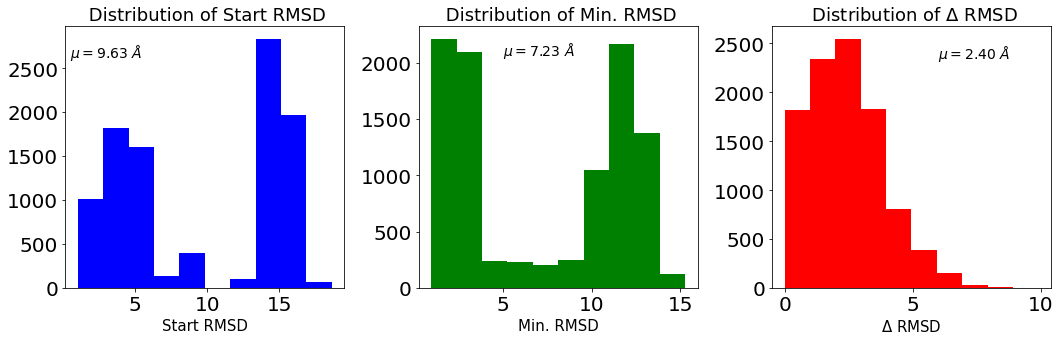

In [57]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].hist(np.array(start),color='blue')
ax[0].set_xlabel('Start RMSD')
ax[0].set_title(' Distribution of Start RMSD')
mu0 = np.array(start).mean()
textstr = r'$\mu=%.2f$ $\AA$' % mu0
ax[0].text(0.5,2800, textstr,  fontsize=14,
        verticalalignment='top')

ax[1].hist(np.array(minim),color='green')
ax[1].set_xlabel('Min. RMSD')
ax[1].set_title(' Distribution of Min. RMSD')
mu1 = np.array(minim).mean()
textstr = r'$\mu=%.2f$ $\AA$' % mu1
ax[1].text(5,2200, textstr, fontsize=14,
        verticalalignment='top')

ax[2].hist(np.array(delta_RMSD),color='red')
ax[2].set_xlabel('$\Delta$ RMSD')
ax[2].set_title(' Distribution of $\Delta$ RMSD')
mu2 = delta_RMSD.mean()
textstr = r'$\mu=%.2f$ $\AA$' % mu2
ax[2].text(6, 2500, textstr, fontsize=14,
        verticalalignment='top')
fig.tight_layout()
fig.show()

# Analysis from DF2

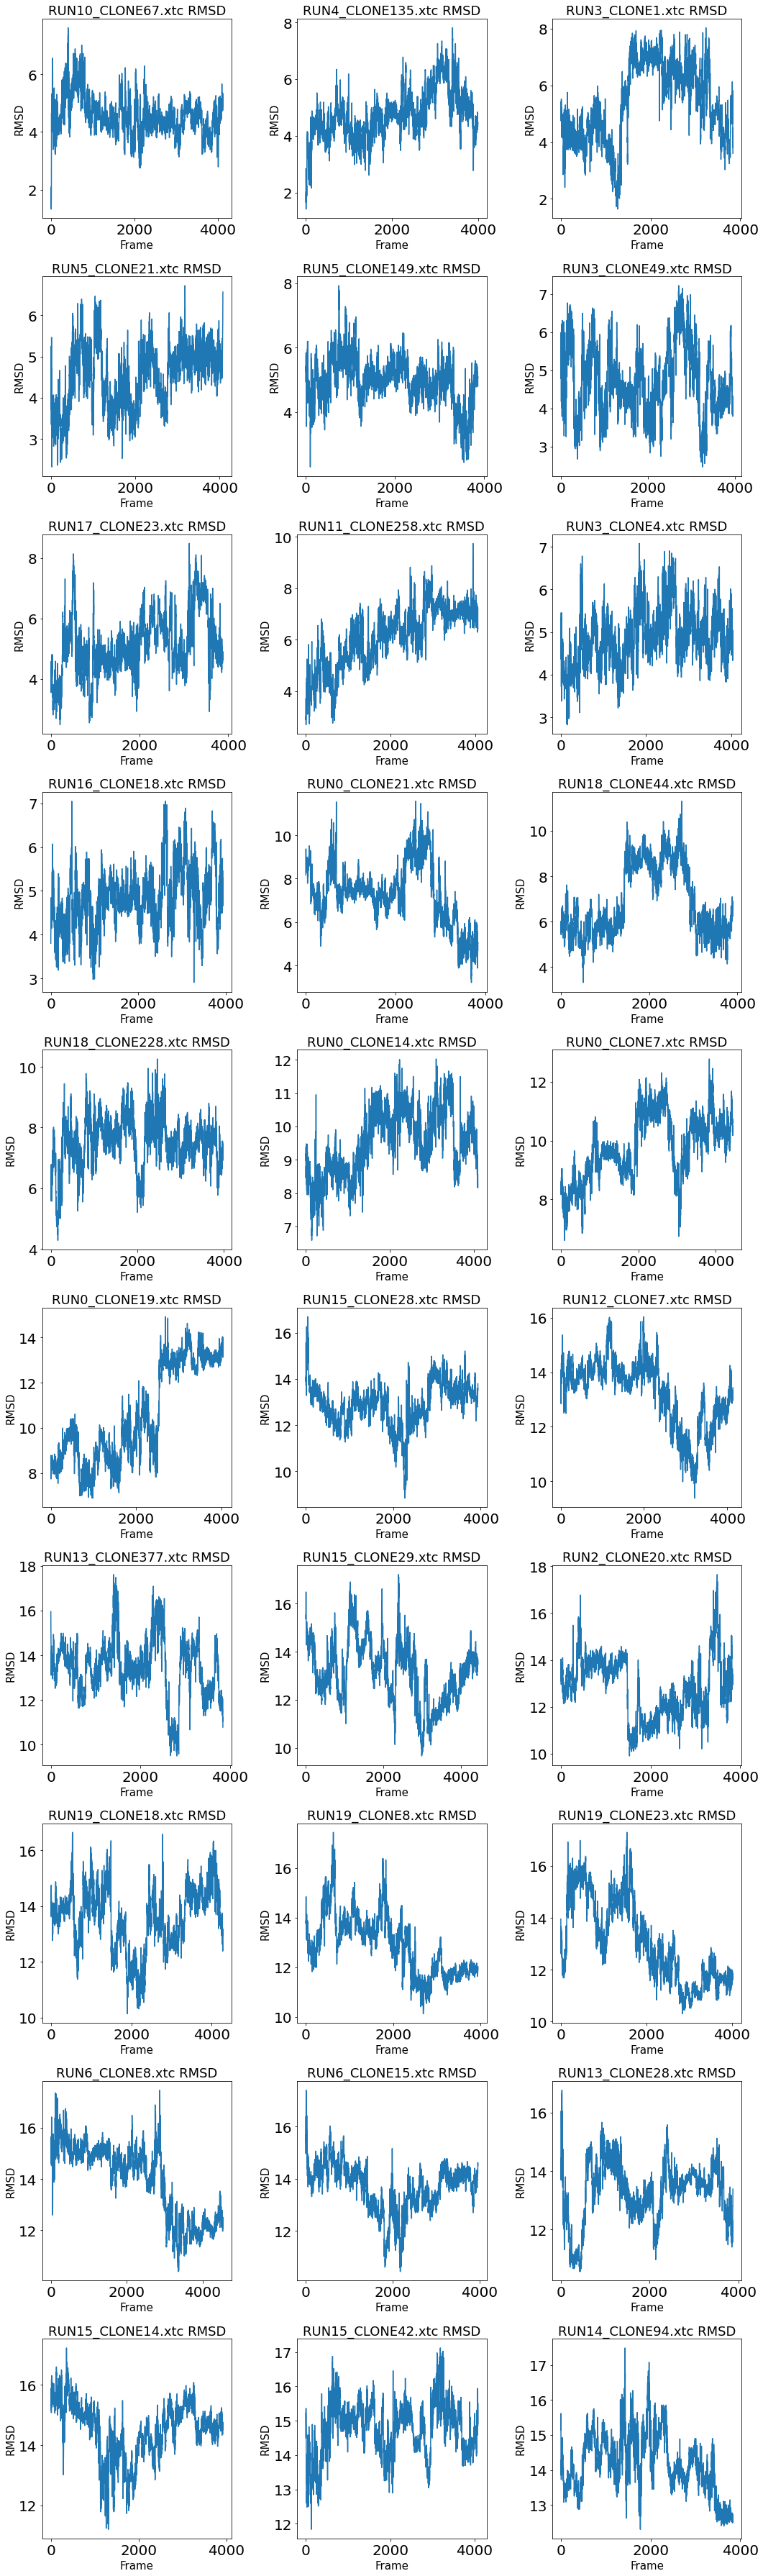

In [676]:
index = df2['index']
index = np.array(index).astype(int)
fig, ax = plt.subplots(10,3, figsize=(15,50))
for i, ax in enumerate(ax.flat):
    ax.plot(RMSD[index[i]]*10)
    name = os.path.basename(traj_list[index[i]])
    ax.set_title(f'{name} RMSD'), ax.set_xlabel('Frame'), ax.set_ylabel('RMSD')
fig.tight_layout()

In [54]:
df2


Traj index  Min. RMSD Traj_length
4    RUN10_CLONE67.xtc  1456        1.3        2060
27   RUN4_CLONE135.xtc  6988        1.4        2000
24     RUN3_CLONE1.xtc  6452        1.6        1920
29    RUN5_CLONE21.xtc  7568        2.3        2040
28   RUN5_CLONE149.xtc  7500        2.3        1930
26    RUN3_CLONE49.xtc  6881        2.5        1980
17   RUN17_CLONE23.xtc  4614        2.5        1939
5   RUN11_CLONE258.xtc  1669        2.7        2030
25     RUN3_CLONE4.xtc  6783        2.8        2020
16   RUN16_CLONE18.xtc  4062        2.9        1970
2     RUN0_CLONE21.xtc   124        3.2        1920
19   RUN18_CLONE44.xtc  5341        3.3        1950
18  RUN18_CLONE228.xtc  5108        4.3        1990
0     RUN0_CLONE14.xtc    46        6.6        2050
3      RUN0_CLONE7.xtc   464        6.6        2220
1     RUN0_CLONE19.xtc   101        6.9        2020
12   RUN15_CLONE28.xtc  3679        8.8        1970
6     RUN12_CLONE7.xtc  2454        9.4        2070
8   RUN13_CLONE377.xtc  2794        9.5        1920
13   RUN15_CLONE29.xtc  3690        9.7        2220
23    RUN2_CLONE20.xtc  6066        9.9        1920
20   RUN19_CLONE18.xtc  5547       10.1        2140
22    RUN19_CLONE8.xtc  5932       10.1        1970
21   RUN19_CLONE23.xtc  5603       10.3        2010
32     RUN6_CLONE8.xtc  8414       10.4        2270
30    RUN6_CLONE15.xtc  7995       10.4        1980
7    RUN13_CLONE28.xtc  2687       10.6        1940
11   RUN15_CLONE14.xtc  3525       11.2        1960
15   RUN15_CLONE42.xtc  3831       11.8        2040
10   RUN14_CLONE94.xtc  3473       12.3        1920
14    RUN15_CLONE3.xtc  3699       12.7        1910
31   RUN6_CLONE405.xtc  8277       12.8        1940
9     RUN14_CLONE0.xtc  2985       12.9        1960
33    RUN7_CLONE11.xtc  8449       13.5        1940

### Run3_Clone1 displays stabilizing effects of TRP11-PHE48 interaction well.
### Folded State <img src="trps.png" width="800" /> 
### Unfolded State  <img src="trp2.png" width="800" /> 
### Run0 Clone21 shows formation of final helix. Seems to show helix portion flipping out, when it flips back in, interaction between SER153 with SER205, SER206 stabilizes an elongated conformation which allows helix to form correctly.
### Flipped Out  <img src="flipout.png" width="800" /> 
### Elongated  <img src="elongated.png" width="800" /> 

In [583]:
sel2 = ref.top.select('residue 56 and name OG')
sel1 = ref.top.select('residue 4 and name HG')
pairs = [[i,j] for i,j in zip(sel1,sel2)]
distances = md.compute_distances(md.load(traj_list[124], top=top),pairs)*10

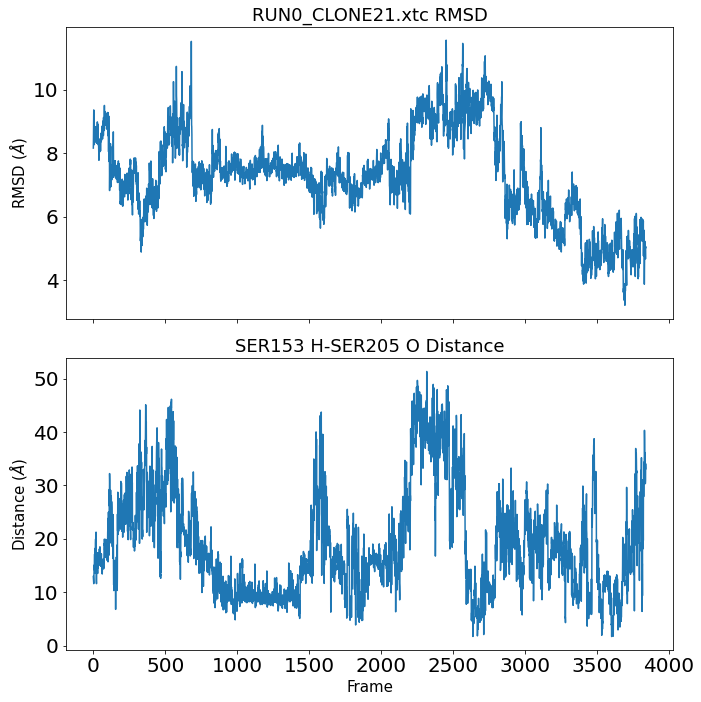

In [597]:
fig,ax = plt.subplots(2,1, figsize=(10,10),sharex=True)
i = 124 #6452
ax[0].plot(RMSD[i]*10)
name = os.path.basename(traj_list[i])
ax[0].set_title(f'{name} RMSD') , ax[0].set_ylabel('RMSD ($\AA$)')
ax[1].plot(np.arange(traj_lengths[124]*2),distances)
ax[1].set_title('SER153 H-SER205 O Distance'), ax[1].set_xlabel('Frame'), ax[1].set_ylabel('Distance ($\AA$)')
fig.tight_layout()

# Analysis from DF3

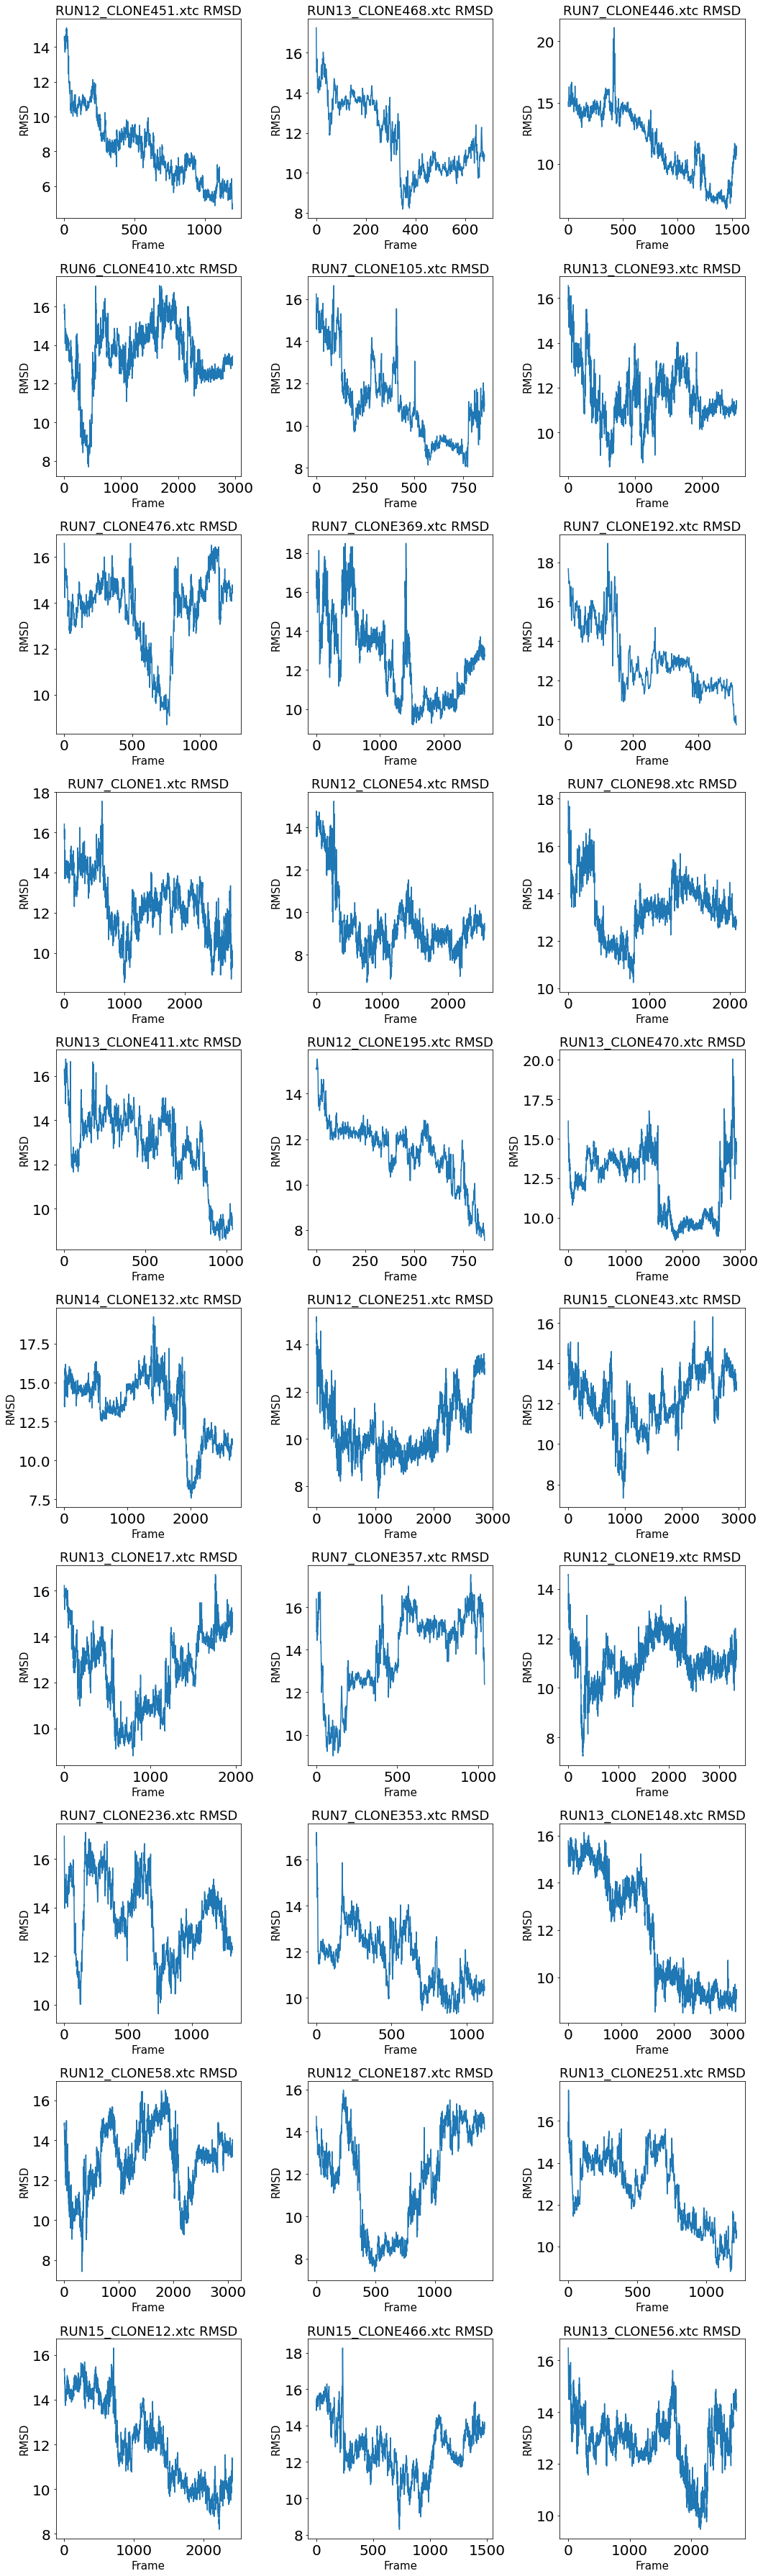

In [675]:
index = df3['index']
index = np.array(index).astype(int)
fig, ax = plt.subplots(10,3, figsize=(15,50))
for i, ax in enumerate(ax.flat):
    ax.plot(RMSD[index[i]]*10)
    name = os.path.basename(traj_list[index[i]])
    ax.set_title(f'{name} RMSD'), ax.set_xlabel('Frame'), ax.set_ylabel('RMSD')
fig.tight_layout()

In [616]:
df3

Traj index $\Delta$ RMSD Traj_length
4   RUN12_CLONE451.xtc  2379           9.9         600
11  RUN13_CLONE468.xtc  2895           9.1         340
27   RUN7_CLONE446.xtc  8819           8.8         770
19   RUN6_CLONE410.xtc  8283           8.4        1480
21   RUN7_CLONE105.xtc  8444           8.2         430
14   RUN13_CLONE93.xtc  2978           8.1        1260
28   RUN7_CLONE476.xtc  8851           7.9         620
26   RUN7_CLONE369.xtc  8735           7.9        1320
22   RUN7_CLONE192.xtc  8540           7.9         260
20     RUN7_CLONE1.xtc  8437           7.9        1400
5    RUN12_CLONE54.xtc  2437           7.8        1280
29    RUN7_CLONE98.xtc  8930           7.7        1040
10  RUN13_CLONE411.xtc  2833           7.7         520
2   RUN12_CLONE195.xtc  2098           7.6         430
12  RUN13_CLONE470.xtc  2898           7.6        1470
15  RUN14_CLONE132.xtc  3022           7.5        1330
3   RUN12_CLONE251.xtc  2159           7.5        1430
17   RUN15_CLONE43.xtc  3842           7.4        1480
8    RUN13_CLONE17.xtc  2565           7.4         980
25   RUN7_CLONE357.xtc  8722           7.4         520
1    RUN12_CLONE19.xtc  2092           7.3        1670
23   RUN7_CLONE236.xtc  8589           7.3         660
24   RUN7_CLONE353.xtc  8718           7.3         560
7   RUN13_CLONE148.xtc  2541           7.3        1590
6    RUN12_CLONE58.xtc  2441           7.3        1540
0   RUN12_CLONE187.xtc  2089           7.3         710
9   RUN13_CLONE251.xtc  2656           7.2         610
16   RUN15_CLONE12.xtc  3503           7.1        1210
18  RUN15_CLONE466.xtc  3881           7.1         740
13   RUN13_CLONE56.xtc  2937           7.0        1370

#### RUN 12 CLONE 451 forms final helix, but is missing second helix, trajectory not long enough to view outcome

# Analysis of DF1

In [680]:
df1

Traj index Min. RMSD Start RMSD
0  RUN0_CLONE371.xtc   303       2.9        9.2

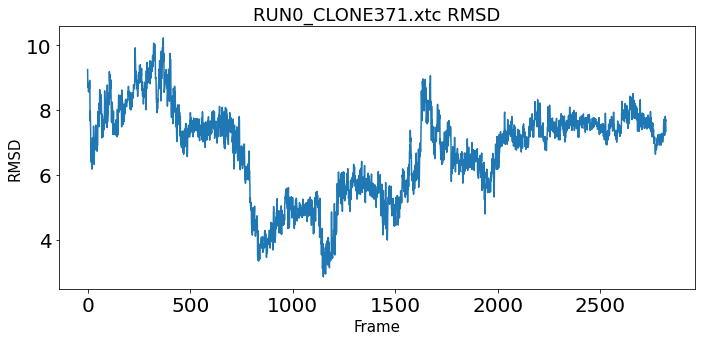

In [689]:
index = df1['index']
index = np.array(index).astype(int)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(RMSD[index[0]]*10)
name = os.path.basename(traj_list[index[0]])
ax.set_title(f'{name} RMSD'), ax.set_xlabel('Frame'), ax.set_ylabel('RMSD')
fig.tight_layout()

## RUN0 Clone 371 shows the highest starting RMSD(9.2 A) to lowest RMSD (2.9 A)
### Start  <img src="start.png" width="800" /> 
### Best Fold  <img src="best_fold.png" width="800" /> 

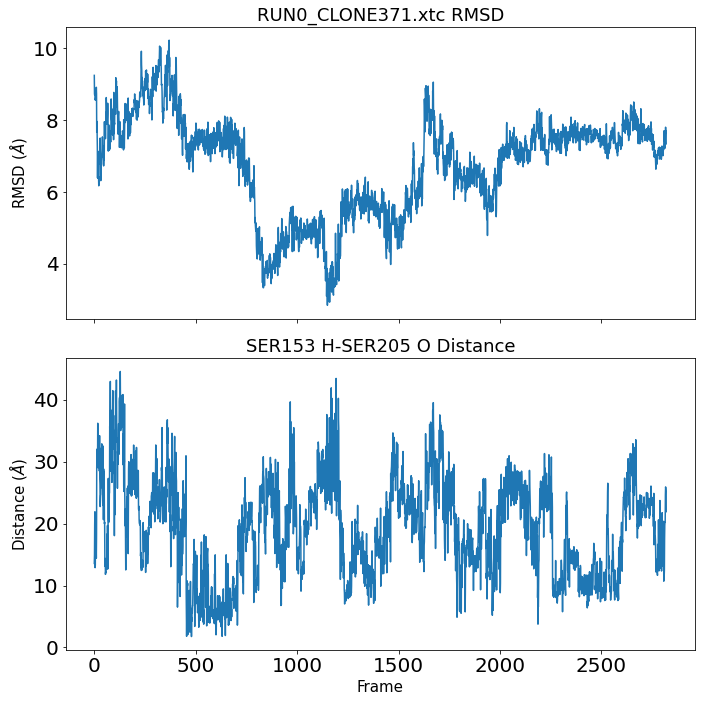

In [693]:
sel2 = ref.top.select('residue 56 and name OG')
sel1 = ref.top.select('residue 4 and name HG')
pairs = [[i,j] for i,j in zip(sel1,sel2)]
distances = md.compute_distances(md.load(traj_list[303], top=top),pairs)*10
fig,ax = plt.subplots(2,1, figsize=(10,10),sharex=True)
i = 303 #6452
ax[0].plot(RMSD[i]*10)
name = os.path.basename(traj_list[i])
ax[0].set_title(f'{name} RMSD') , ax[0].set_ylabel('RMSD ($\AA$)')
ax[1].plot(np.arange(traj_lengths[i]*2),distances)
ax[1].set_title('SER153 H-SER205 O Distance'), ax[1].set_xlabel('Frame'), ax[1].set_ylabel('Distance ($\AA$)')
fig.tight_layout()